<a href="https://colab.research.google.com/github/george-le/handbook/blob/master/Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Next Steps


1.   Remove msdrg codes/descriptions from final_data
2.   Cast fields appropriately

Useful resources


*   [Exploratory Analysis](https://github.com/Tanu-N-Prabhu/Python/blob/master/Exploratory_data_Analysis.ipynb)
*   [Linear Regression](https://nbviewer.ipython.org/github/justmarkham/DAT4/blob/master/notebooks/08_linear_regression.ipynb)
* [Index of Resources](https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks#statistics-machine-learning-and-data-science)





In [1]:
#@title Run Imports and Authenticate to BigQuery
import pandas as pd
import numpy as np
from google.colab import auth
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from googleapiclient.discovery import build
auth.authenticate_user()
print('Authenticated')
!apt-get install libgeos-dev
!pip3 install -U git+https://github.com/matplotlib/basemap.git  # latest Version from Source 1.2
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline
pd.options.display.float_format = '{:20,.2f}'.format

Authenticated
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
libgeos-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
  Cloning https://github.com/matplotlib/basemap.git to /tmp/pip-req-build-5_ggnk3g
  Running command git clone -q https://github.com/matplotlib/basemap.git /tmp/pip-req-build-5_ggnk3g
     |████████████████████████████████| 6.6MB 5.2MB/s 
     |████████████████████████████████| 225kB 45.3MB/s 
  Created wheel for basemap: filename=basemap-1.2.2+dev-cp37-cp37m-linux_x86_64.whl size=121759594 sha256=e220fcc6d01705f9f2870f1a5e97ed192e3137e57845cd9689b9817bd07ec13d
  Stored in directory: /tmp/pip-ephem-wheel-cache-47fc4_39/wheels/3f/f3/56/de548b66967d0d661612b7618022e2c0d4b86b9a638cf6ccf3
  Created wheel for pyshp: filename=pyshp-2.1.3-cp37-none-any.whl size=37325 sha256=41b20b0d285bb02c75aa683042a11fb7ea2c46438f54dd6f0092

In [2]:
def get_memory():
  from psutil import virtual_memory
  ram_gb = virtual_memory().total / 1e9
  print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

In [3]:
%%bigquery --project provider-datalake df
select distinct fd.*, acs.* except(county_name, year), market.* except(county_name, year, facility_number, county_fips_code, total_discharges) 
from `provider-datalake.thedoctorate_clean.final_data` fd
 left join `provider-datalake.census_acs.acs_census_data_final` acs 
   on acs.year = fd.year and lower(acs.county_name) = lower(fd.county_name)
left join `provider-datalake.thedoctorate_clean.market_share_county` market 
   on market.year=fd.year and market.facility_number=fd.facility_number and lower(market.county_name) = lower(acs.county_name)
where 
    fd.year not in (2019, 2020)
    and fd.year = 2012
    and market.county_name is not null

In [4]:
%%bigquery --project provider-datalake msdrg_df
SELECT
year, msdrg_description, msdrg_code, facility_name, cast(avg_chg as float64) as avg_chg, 
cast(no_of_discharges as int64) no_of_discharges
from `thedoctorate_clean.top25_hospital`
where 
# msdrg_code in ('897','603','690','885','291','641','872','392','871','683','378','313','194','470','794','795','189','775','292','774','765','766','793','853','743','190')
# AND msdrg_code not in ('853')
# AND 
facility_name != 'STATEWIDE'
# and 
# year=2019

# Descriptive Statistics

In [6]:
# see the first 10 rows
# df.head(n=5)
# df.dtypes
print(df.describe(include='all'))
print('Null values', df.isnull().sum())

                   stf_beds  ...           county_hhi
count              6,105.00  ...             6,105.00
unique                  nan  ...                  nan
top                     nan  ...                  nan
freq                    nan  ...                  nan
mean                 196.22  ...             3,641.85
std                  146.49  ...             1,172.51
min                   10.00  ...             1,549.72
25%                   95.00  ...             3,176.35
50%                  156.00  ...             3,315.09
75%                  270.00  ...             4,025.99
max                  884.00  ...            11,047.80

[11 rows x 46 columns]
Null values stf_beds                            0
total_discharges                    0
facility_county_name                0
facility_number                     0
facility_name                       0
msdrg_code                          0
msdrg_description                   0
year                                0
no_of_discha

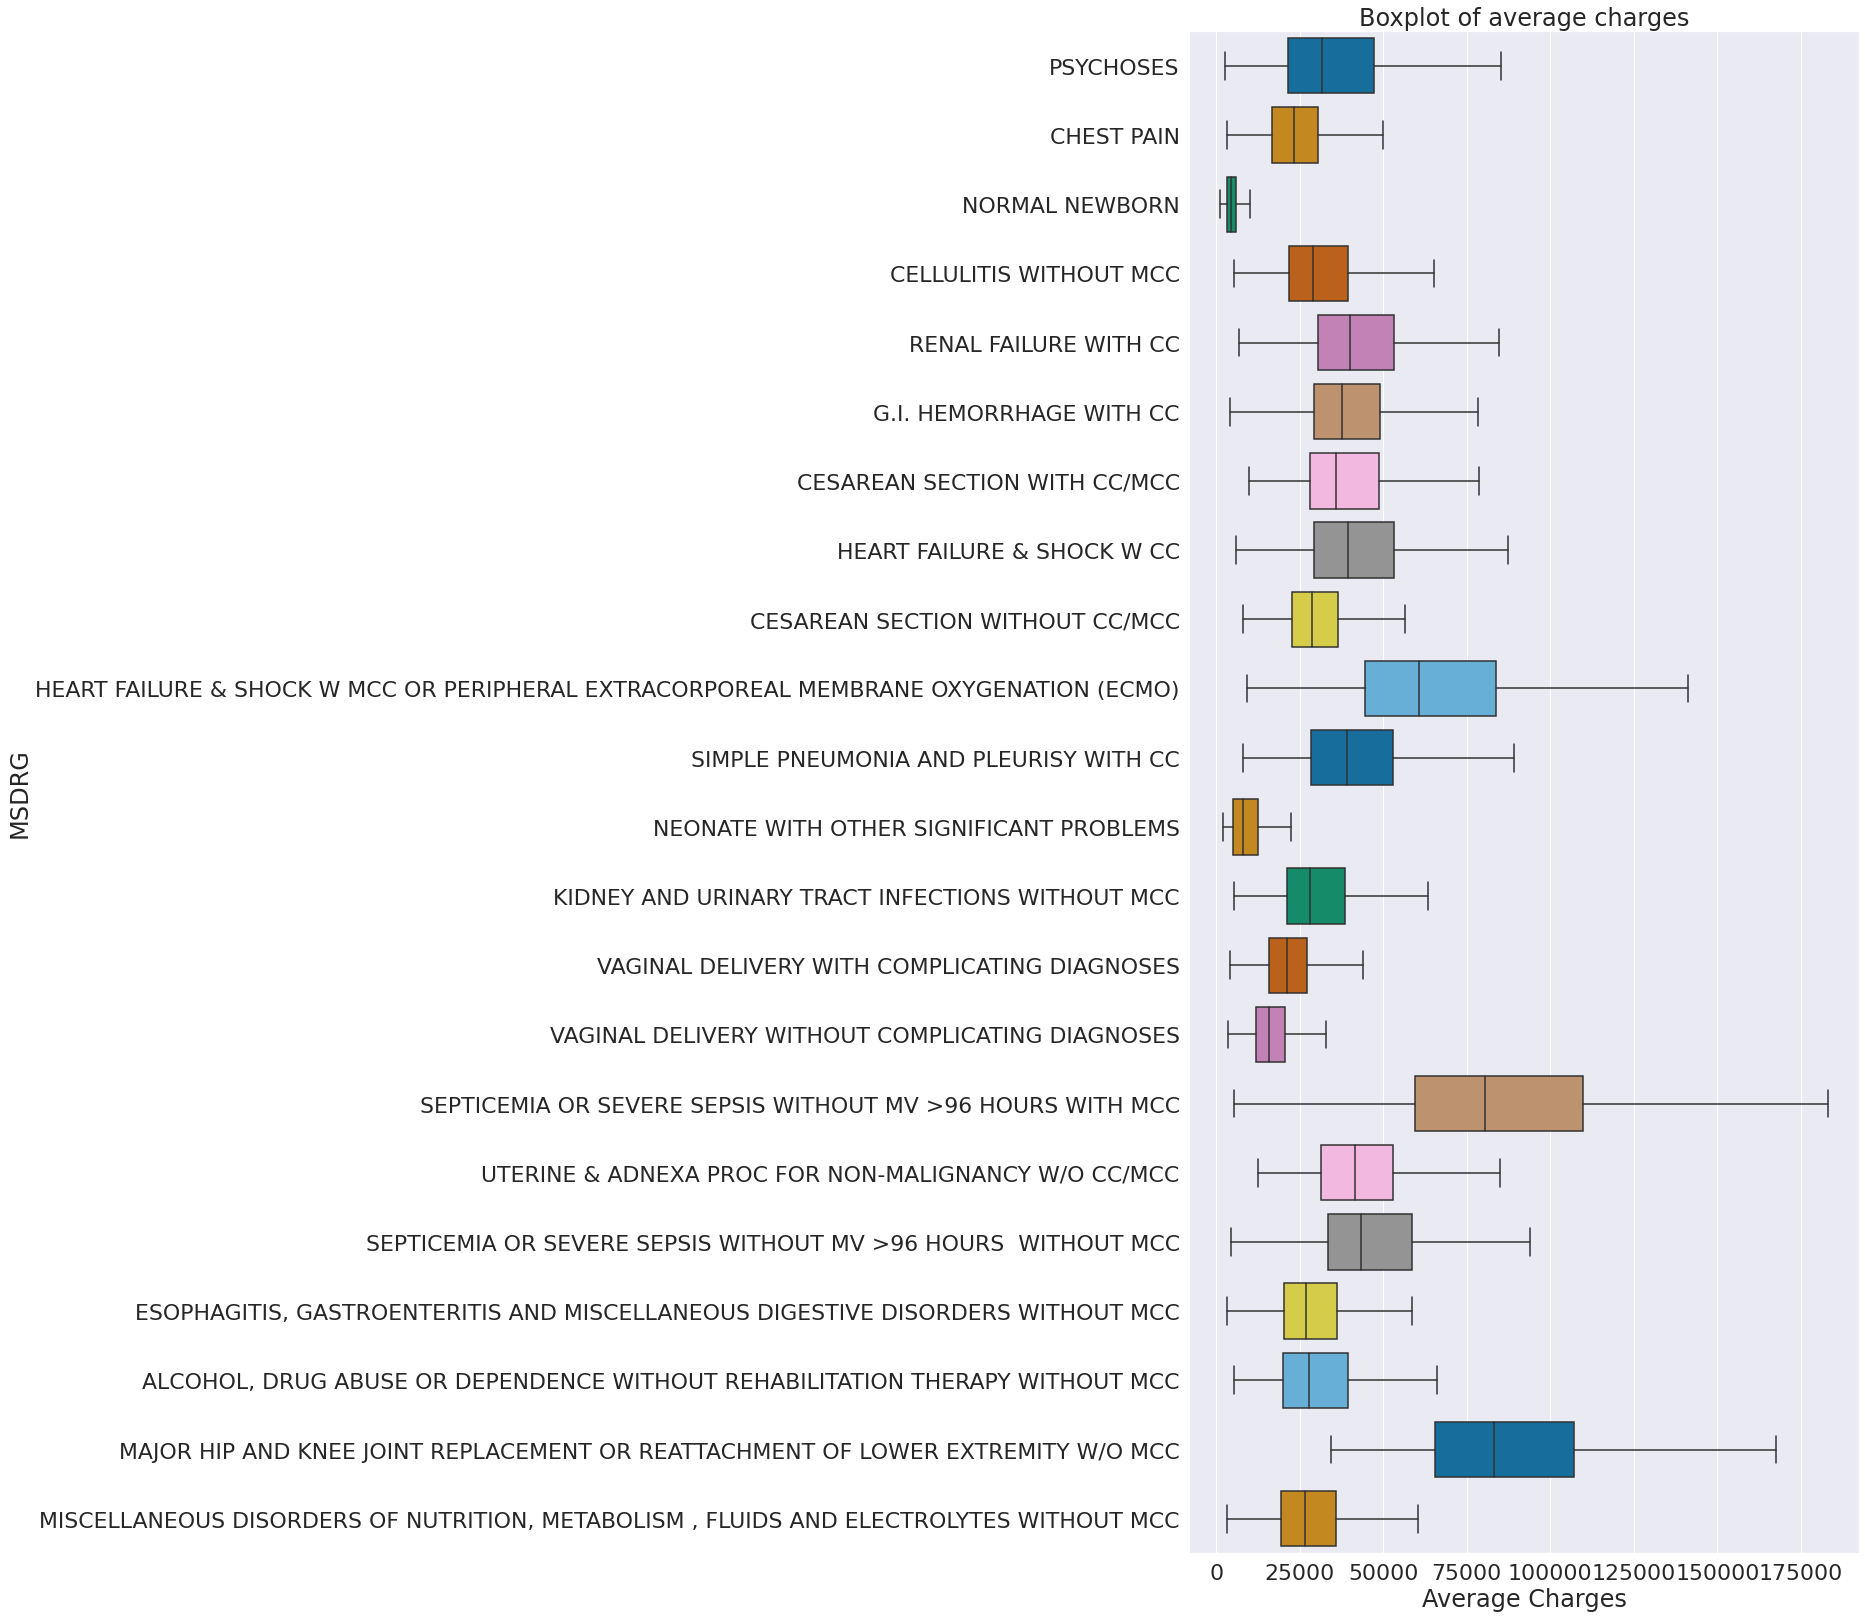

In [7]:
#@title Box Plot of Average Charges
import seaborn as sns                       #visualisation
fig = plt.gcf()
fig.set_size_inches(12, 28)
sns.set(font_scale=2)
sns.boxplot(x='avg_chg', y='msdrg_description', data=df, showfliers=False,
                #  width=0.5,
                
                 palette="colorblind",
            orient='h', dodge=True)
plt.title("Boxplot of average charges")
plt.suptitle("")
plt.xlabel("Average Charges")
plt.ylabel("MSDRG")
plt.show()

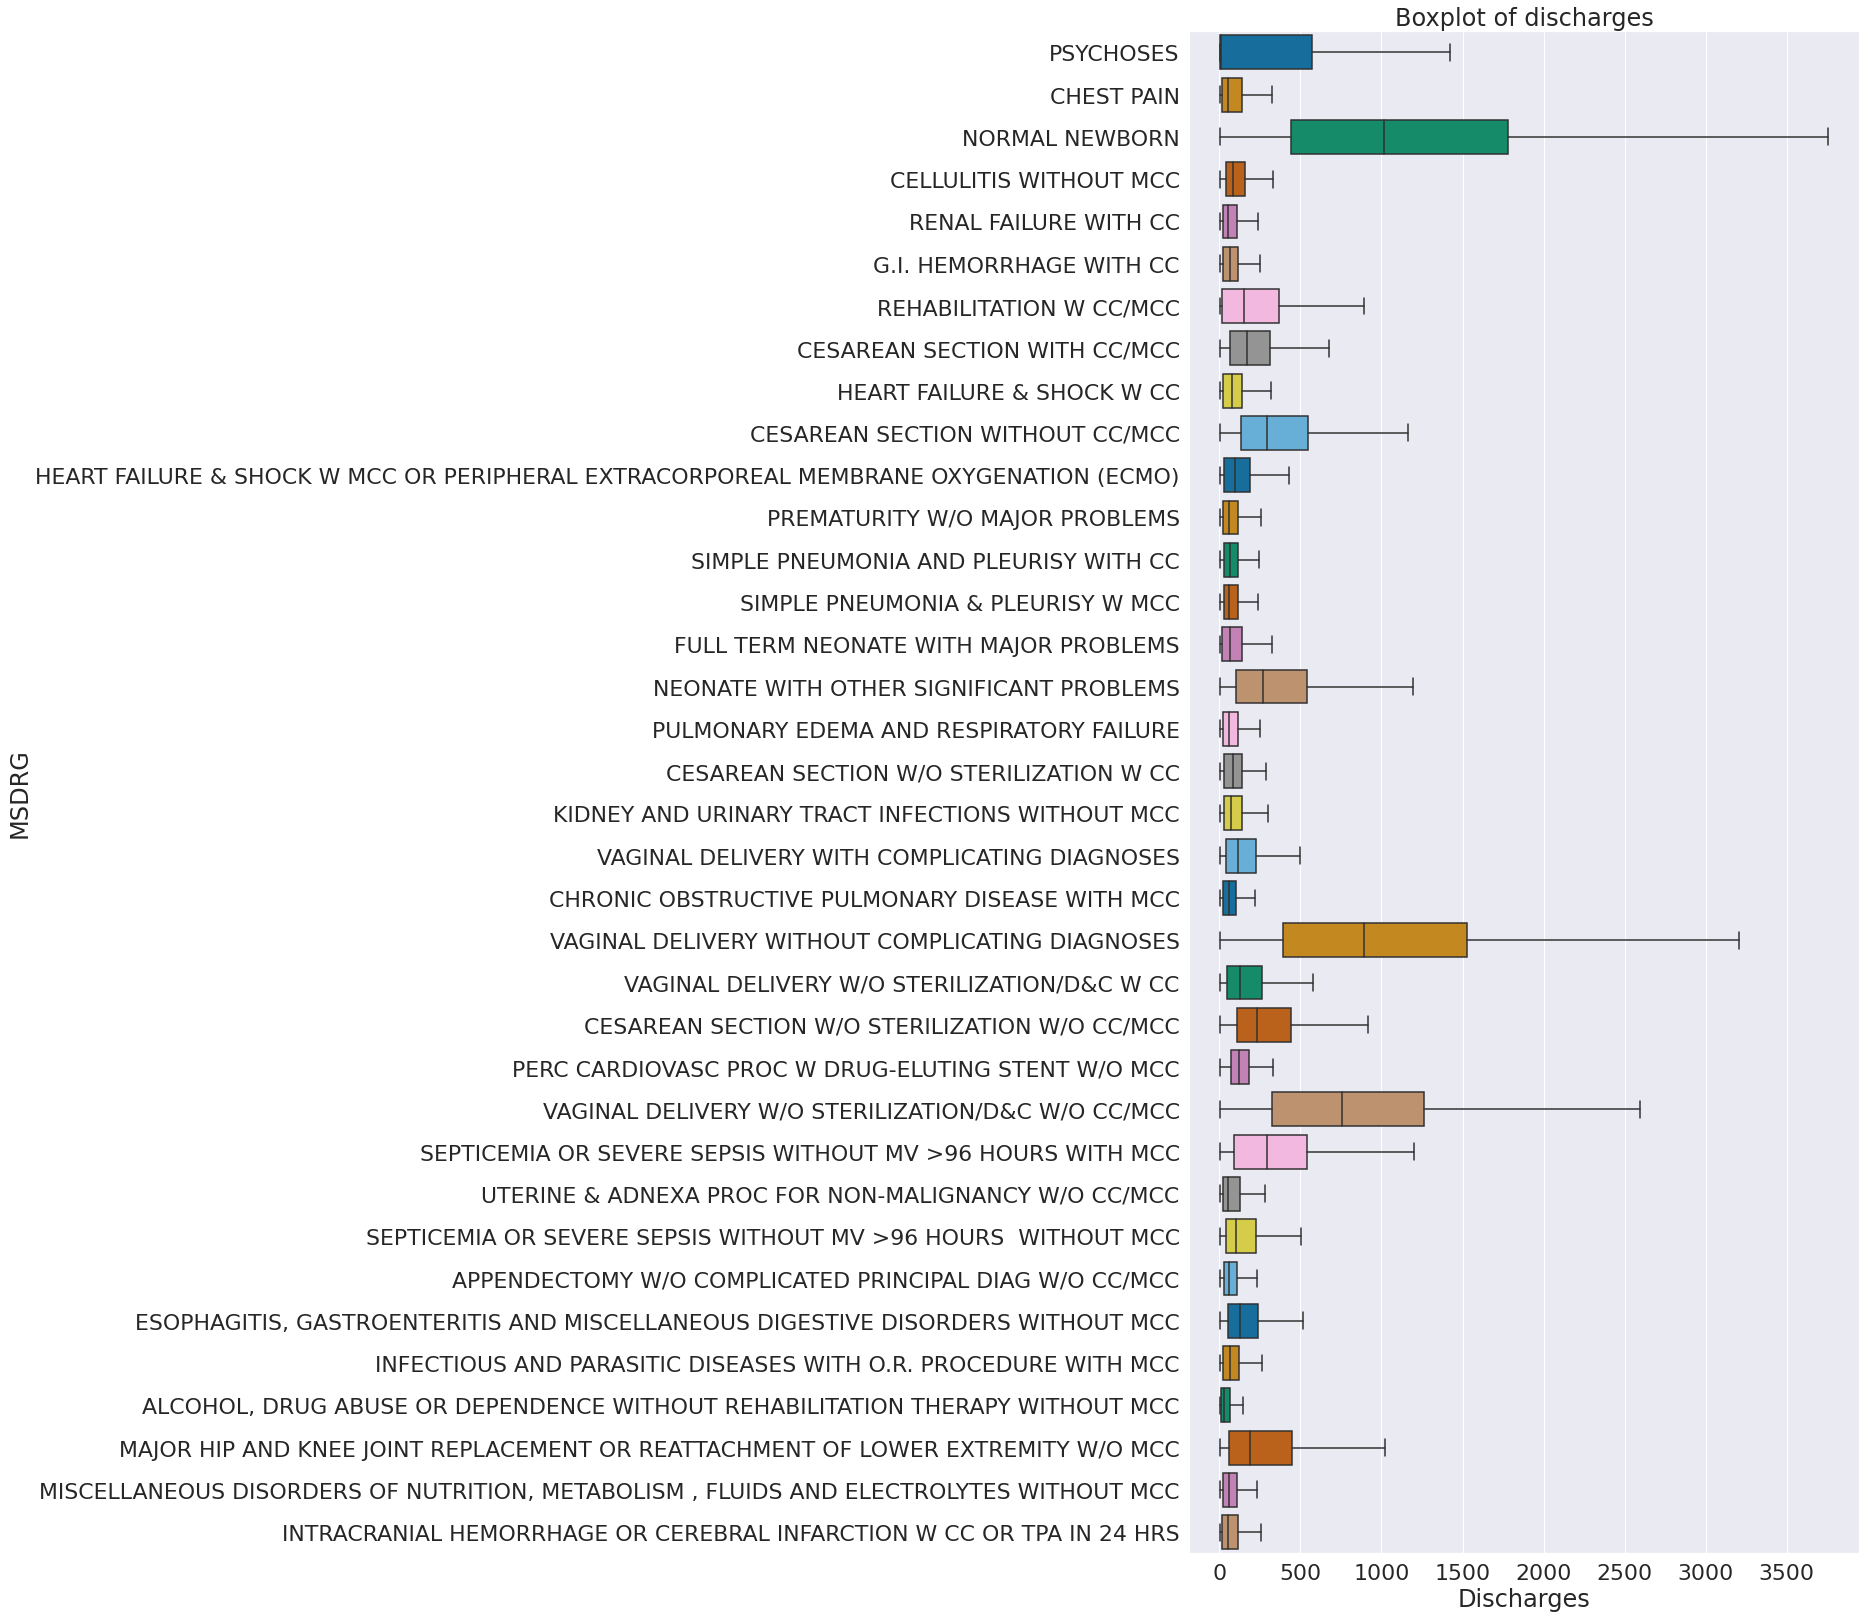

In [8]:
#@title Box Plot of Discharges
import seaborn as sns                       #visualisation
fig = plt.gcf()
fig.set_size_inches(12, 28)
sns.set(font_scale=2)
sns.boxplot(x='no_of_discharges', y='msdrg_description', data=msdrg_df, showfliers=False,
                #  width=0.5,
                 palette="colorblind",
            orient='h', dodge=True)
plt.title("Boxplot of discharges")
plt.suptitle("")
plt.xlabel("Discharges")
plt.ylabel("MSDRG")
plt.show()

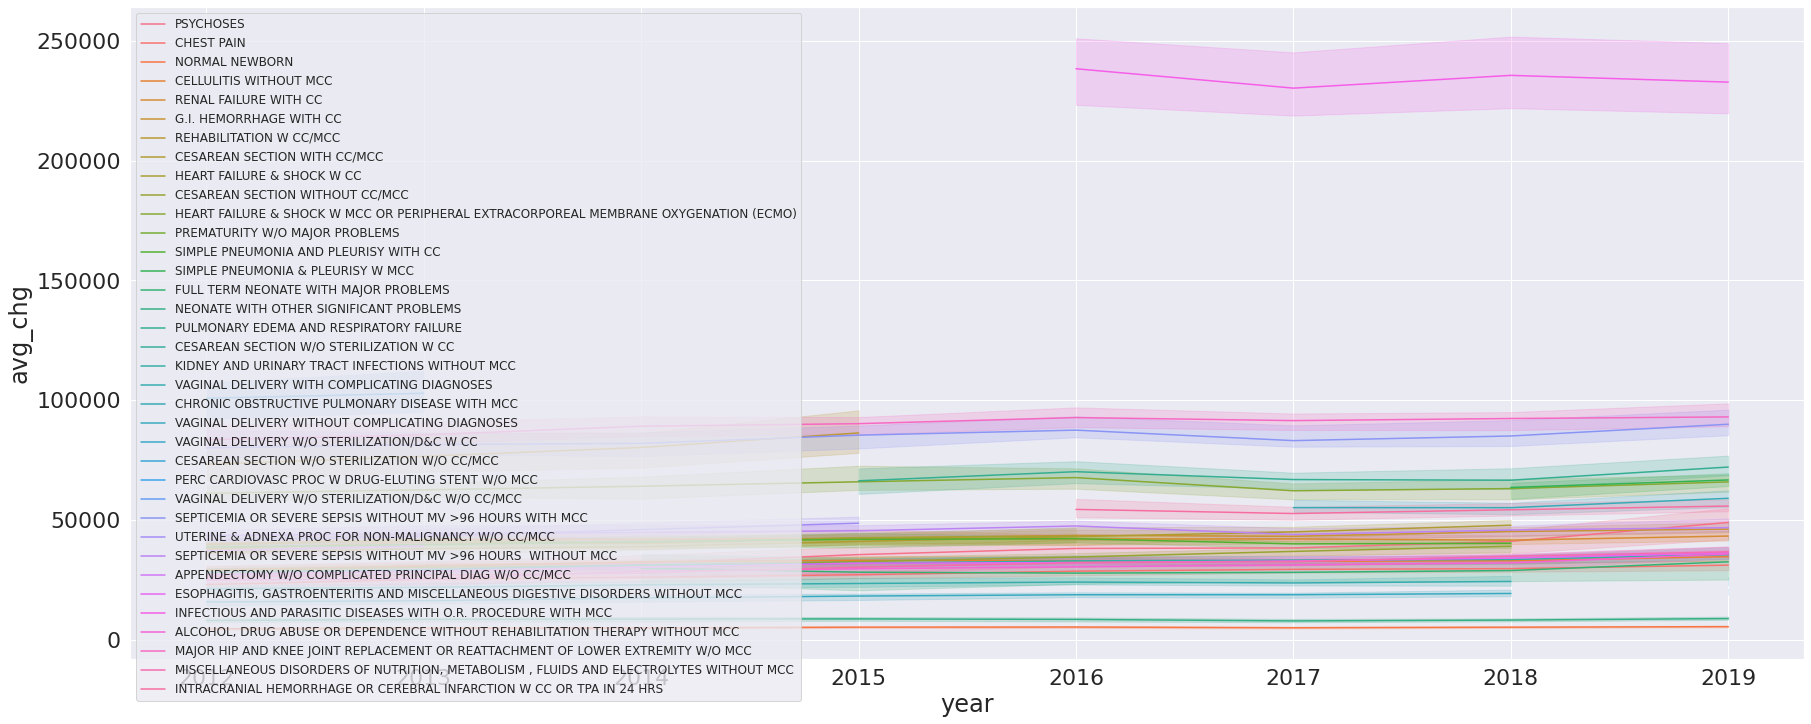

In [13]:
#@title Median Price By MSDRG (ALL)
#@markdown - Shows mean and 95% confidence interval
fig = plt.gcf()

df2 = msdrg_df
fig.set_size_inches(30, 12)
# filters = ('PSYCHOSES','RENAL FAILURE WITH CC','CHEST PAIN', 'NORMAL NEWBORN','ALCOHOL, DRUG ABUSE OR DEPENDENCE WITHOUT REHABILITATION THERAPY WITHOUT MCC')
# df2 = msdrg_df[msdrg_df['msdrg_description'].isin(filters)]
line = sns.lineplot(data=df2, x='year', y='avg_chg', hue='msdrg_description', estimator=np.median)
# line.legend(bbox_to_anchor= (1.03, 1) );
plt.legend(loc='best')
line.legend(fontsize = 12) 
plt.show()

#look into psychoses and other spikes in 2016 to see which hospitals were driving. 


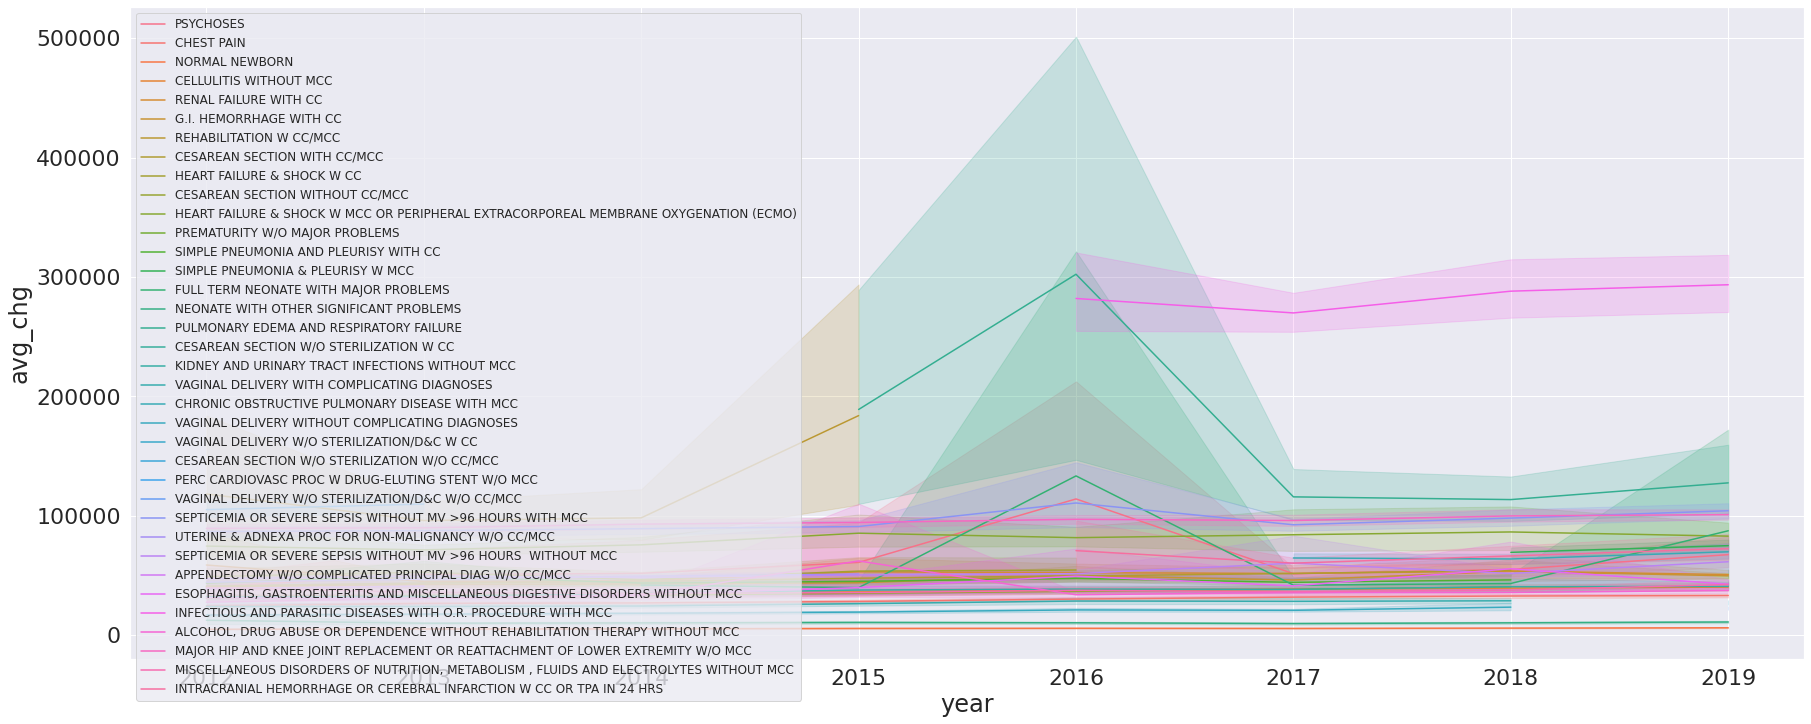

In [12]:
#@title Average Price By MSDRG (ALL)
#@markdown - Shows mean and 95% confidence interval
fig = plt.gcf()

df2 = msdrg_df
fig.set_size_inches(30, 12)
# filters = ('PSYCHOSES','RENAL FAILURE WITH CC','CHEST PAIN', 'NORMAL NEWBORN','ALCOHOL, DRUG ABUSE OR DEPENDENCE WITHOUT REHABILITATION THERAPY WITHOUT MCC')
# df2 = msdrg_df[msdrg_df['msdrg_description'].isin(filters)]
line = sns.lineplot(data=df2, x='year', y='avg_chg', hue='msdrg_description')
# line.legend(bbox_to_anchor= (1.03, 1) );
plt.legend(loc='best')
line.legend(fontsize = 12) 
plt.show()

#look into psychoses and other spikes in 2016 to see which hospitals were driving. 


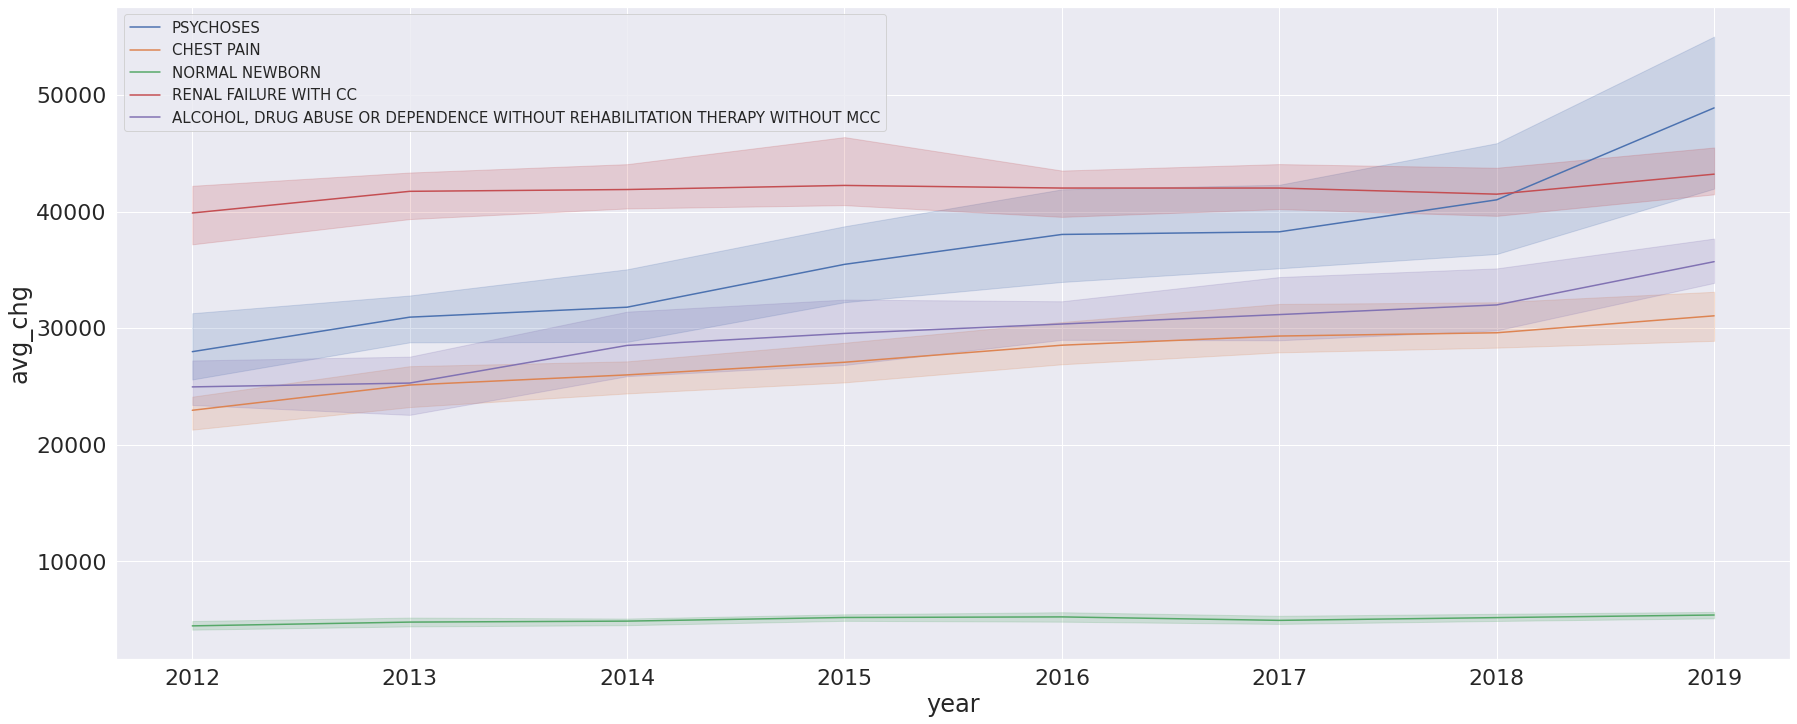

In [15]:
#@title Median Price By MSDRG ('PSYCHOSES','RENAL FAILURE WITH CC','CHEST PAIN', 'NORMAL NEWBORN','ALCOHOL, DRUG ABUSE OR DEPENDENCE WITHOUT REHABILITATION THERAPY WITHOUT MCC')
#@markdown - Shows mean and 95% confidence interval
fig = plt.gcf()

# df2 = msdrg_df
fig.set_size_inches(30, 12)
filters = ('PSYCHOSES','RENAL FAILURE WITH CC','CHEST PAIN', 'NORMAL NEWBORN','ALCOHOL, DRUG ABUSE OR DEPENDENCE WITHOUT REHABILITATION THERAPY WITHOUT MCC')
df2 = msdrg_df[msdrg_df['msdrg_description'].isin(filters)]
line = sns.lineplot(data=df2, x='year', y='avg_chg', hue='msdrg_description', estimator=np.median)
# line.legend(bbox_to_anchor= (1.03, 1) );
plt.legend(loc='best')
line.legend(fontsize = 15) 
plt.show()


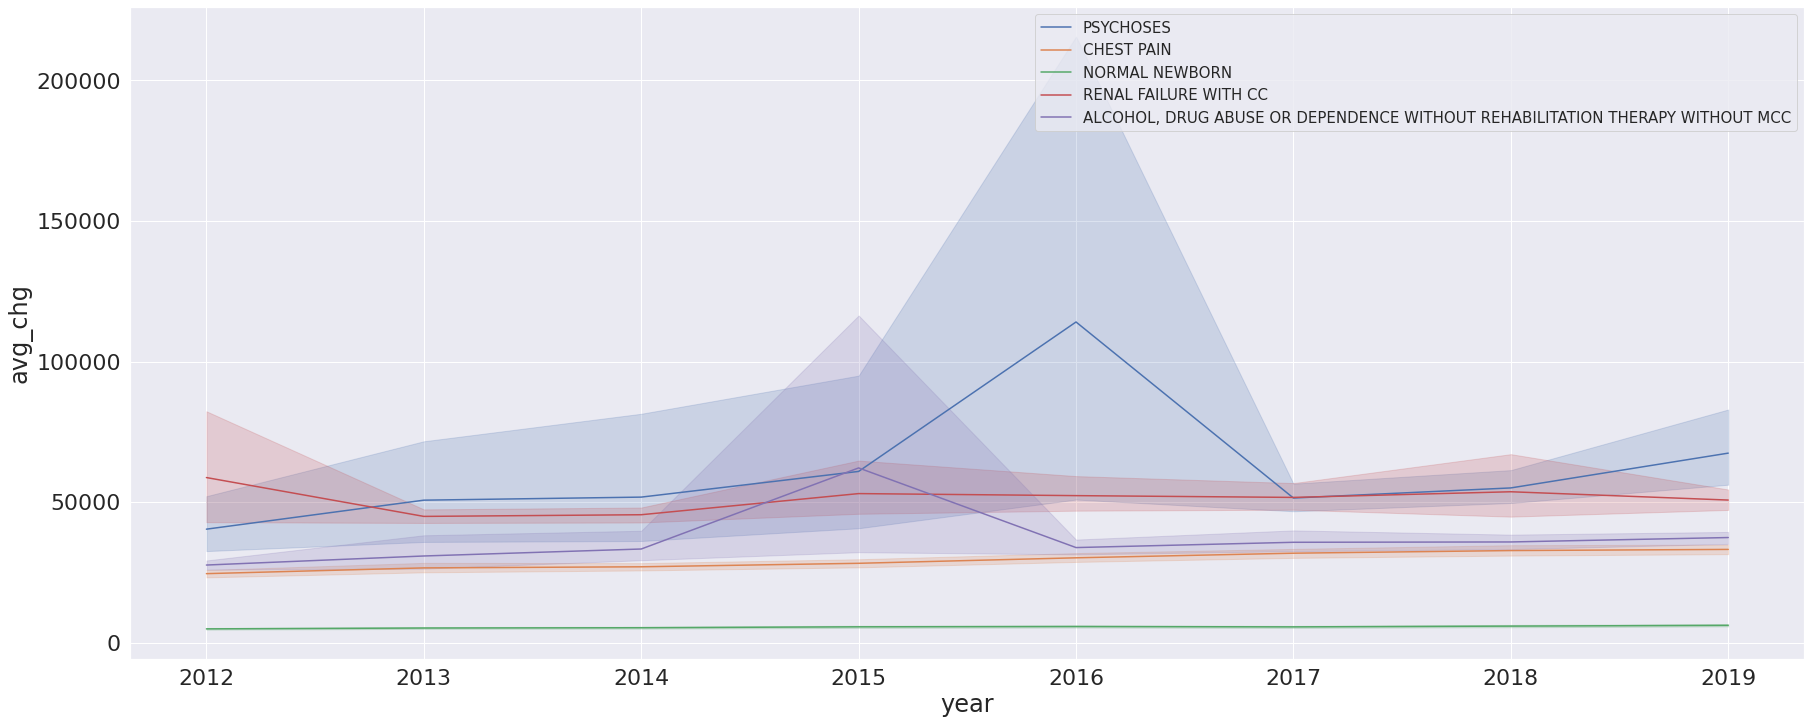

In [16]:
#@title Average Price By MSDRG ('PSYCHOSES','RENAL FAILURE WITH CC','CHEST PAIN', 'NORMAL NEWBORN','ALCOHOL, DRUG ABUSE OR DEPENDENCE WITHOUT REHABILITATION THERAPY WITHOUT MCC')
#@markdown - Shows mean and 95% confidence interval
fig = plt.gcf()

# df2 = msdrg_df
fig.set_size_inches(30, 12)
filters = ('PSYCHOSES','RENAL FAILURE WITH CC','CHEST PAIN', 'NORMAL NEWBORN','ALCOHOL, DRUG ABUSE OR DEPENDENCE WITHOUT REHABILITATION THERAPY WITHOUT MCC')
df2 = msdrg_df[msdrg_df['msdrg_description'].isin(filters)]
line = sns.lineplot(data=df2, x='year', y='avg_chg', hue='msdrg_description')
# line.legend(bbox_to_anchor= (1.03, 1) );
plt.legend(loc='best')
line.legend(fontsize = 15) 
plt.show()


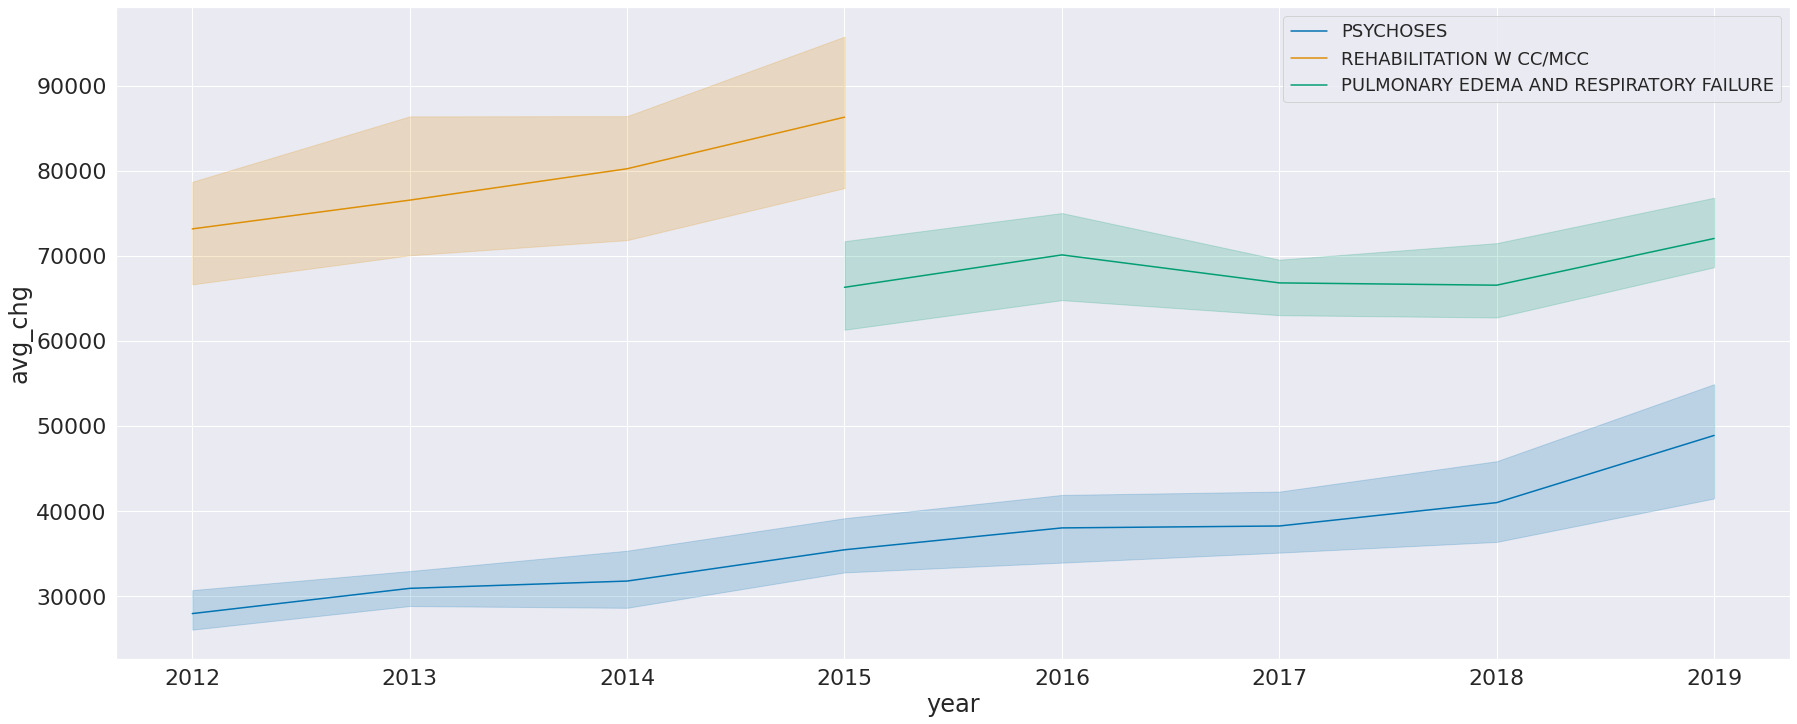

In [17]:
#@title Median Price By MSDRG ('PSYCHOSES','PULMONARY EDEMA AND RESPIRATORY FAILURE','REHABILITATION W CC/MCC')
#@markdown - Shows mean and 95% confidence interval
fig = plt.gcf()

fig.set_size_inches(30, 12)
filters = ('PSYCHOSES','PULMONARY EDEMA AND RESPIRATORY FAILURE','REHABILITATION W CC/MCC')
df2 = msdrg_df[msdrg_df['msdrg_description'].isin(filters)]
line = sns.lineplot(data=df2, x='year', y='avg_chg', hue='msdrg_description',palette="colorblind", estimator=np.median)
# line.legend(bbox_to_anchor= (1.03, 1) );
plt.legend(loc='best')
line.legend(fontsize = 18) 
plt.show()

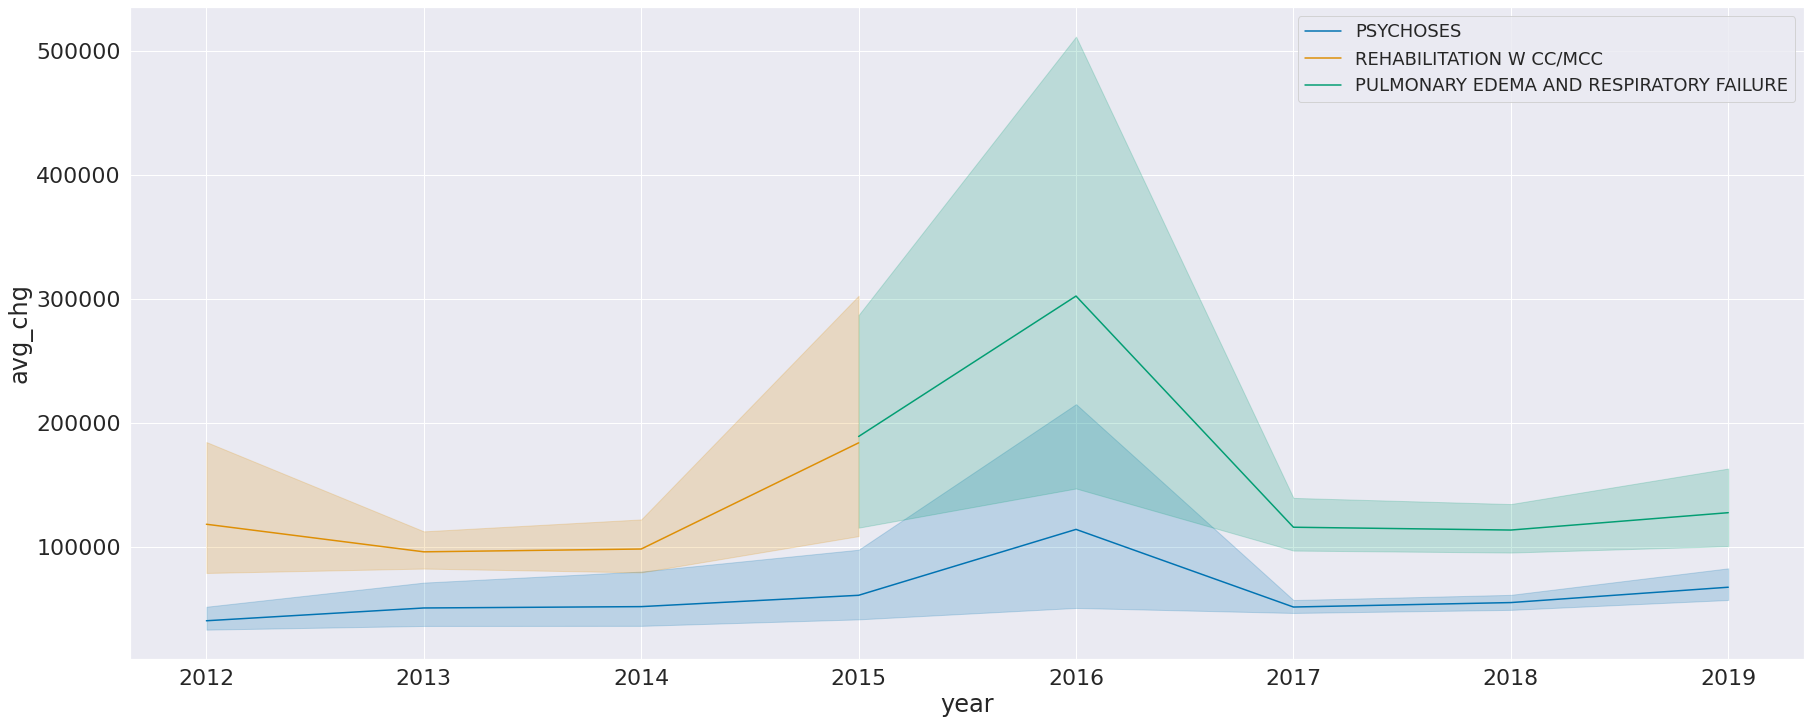

In [18]:
#@title Average Price By MSDRG ('PSYCHOSES','PULMONARY EDEMA AND RESPIRATORY FAILURE','REHABILITATION W CC/MCC')
#@markdown - Shows mean and 95% confidence interval
fig = plt.gcf()

fig.set_size_inches(30, 12)
filters = ('PSYCHOSES','PULMONARY EDEMA AND RESPIRATORY FAILURE','REHABILITATION W CC/MCC')
df2 = msdrg_df[msdrg_df['msdrg_description'].isin(filters)]
line = sns.lineplot(data=df2, x='year', y='avg_chg', hue='msdrg_description',palette="colorblind" )
# line.legend(bbox_to_anchor= (1.03, 1) );
plt.legend(loc='best')
line.legend(fontsize = 18) 
plt.show()

In [33]:
msdrg_df[msdrg_df['msdrg_description']=='PSYCHOSES'].describe()
outliers = msdrg_df[msdrg_df['msdrg_description']=='PSYCHOSES']
print(outliers[outliers['avg_chg'] > 900000].sort_values(by='avg_chg'))
print("Outliers rare pretty clear.")

      year msdrg_description  ...              avg_chg no_of_discharges
2321  2012         PSYCHOSES  ...         1,254,409.54                1
1677  2015         PSYCHOSES  ...         1,458,105.15                2
963   2013         PSYCHOSES  ...         1,918,785.93                4
1631  2019         PSYCHOSES  ...         2,148,442.00                3
691   2013         PSYCHOSES  ...         2,289,338.90                2
623   2016         PSYCHOSES  ...         2,406,994.31                1
269   2014         PSYCHOSES  ...         4,378,892.62                1
1864  2015         PSYCHOSES  ...         4,764,258.49                1
373   2016         PSYCHOSES  ...         6,597,750.33                3
607   2016         PSYCHOSES  ...        12,582,994.90                9

[10 rows x 6 columns]
Outliers rare pretty clear.


In [ ]:
%%bigquery --project provider-datalake fac_drg_df
SELECT distinct year, facility_county_name, f.facility_name, f.facility_number, sum(cast(total_discharges as int64)) as total_discharges
FROM `provider-datalake.thedoctorate_clean.final_data` f
where year = 2019
group by 1,2,3,4

         year  total_discharges
count   328.0      3.280000e+02
mean   2019.0      8.540573e+05
std       0.0      7.423634e+05
min    2019.0      3.500000e+01
25%    2019.0      2.205945e+05
50%    2019.0      6.961315e+05
75%    2019.0      1.332546e+06
max    2019.0      3.247993e+06
                                facility_name  total_discharges
22   COMMUNITY REGIONAL MEDICAL CENTER-FRESNO           2910097
93                     LAC+USC MEDICAL CENTER           3247993
122       HOAG MEMORIAL HOSPITAL PRESBYTERIAN           3072471
175                    SCRIPPS MERCY HOSPITAL           2868069
                                         facility_name  total_discharges
300               TOTALLY KIDS REHABILITATION HOSPITAL               832
304                          SONOMA SPECIALTY HOSPITAL               170
314            HEALTHBRIDGE CHILDREN'S HOSPITAL-ORANGE               354
321  CHILDREN'S HEALTHCARE ORGANIZATION OF NORTHERN...                35
324                        

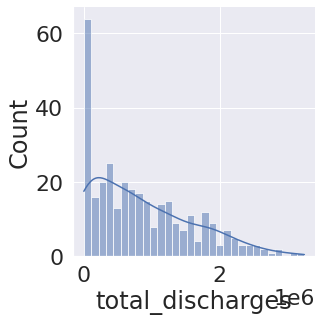

In [ ]:
#@title Histogram of Discharges
print(fac_drg_df.describe())
# threshold
outliers = fac_drg_df[fac_drg_df['total_discharges'] > 2800000]
print(outliers[['facility_name', 'total_discharges']])
outliers = fac_drg_df[fac_drg_df['total_discharges'] < 1000]
print(outliers[['facility_name', 'total_discharges']])
sns.displot(fac_drg_df['total_discharges'], bins=30, kde=True)
plt.show()


,stf_beds,total_discharges,netInpatientRev,grossInpatientRevPerDischarge
stf_beds,1.000000,0.705727,0.771389,0.104614
total_discharges,0.705727,1.000000,0.665418,-0.121850
netInpatientRev,0.771389,0.665418,1.000000,0.157205
grossInpatientRevPerDischarge,0.104614,-0.121850,0.157205,1.000000


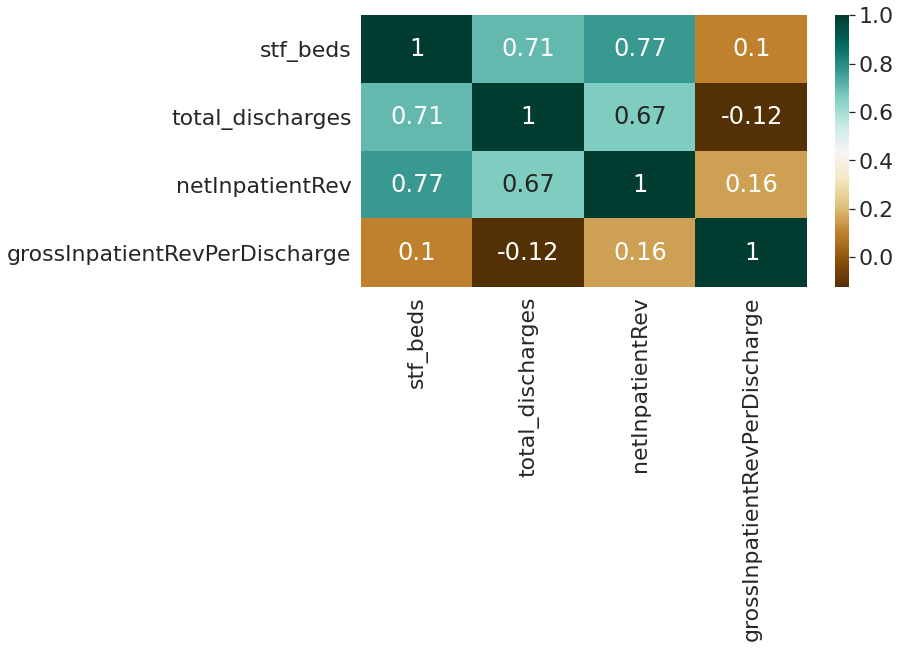

In [ ]:
df_corr = df.filter(['stf_beds', 'total_discharges','netInpatientRev','grossInpatientRevPerDischarge'], axis=1)
df_corr
plt.figure(figsize=(10,5))
c= df_corr.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

## Map of Hospitals and # of Beds

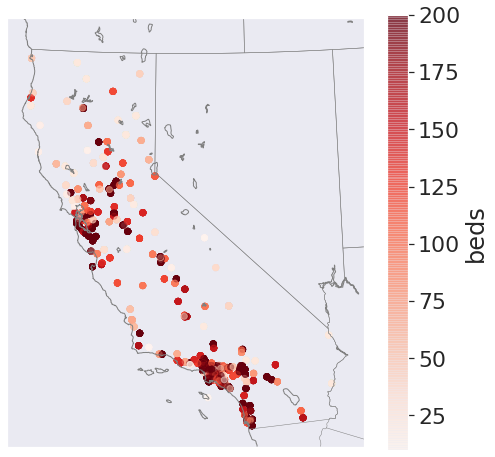

In [ ]:
#@title Generate Map
lon = df['LONGITUDE']
lat = df['LATITUDE']
beds = df['stf_beds']
discharges = df['total_discharges']

# 1. Draw the map background
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=37.5, lon_0=-119,
            width=1E6, height=1.2E6)
# m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
# m.scatter(lon, lat, latlon=True,
#           c=beds, 
#           s=np.log10(discharges),
#           cmap='Reds', alpha=0.5)
m.scatter(lon, lat, latlon=True,
          c=beds, 
          # s=np.log10(discharges),
          cmap='Reds', alpha=0.5)

# 3. create colorbar and legend
plt.colorbar(label=r'beds')
plt.clim(min(beds), 200)

# # # make legend with dummy points
# for a in [100, 300, 500]:
#     plt.scatter([], [], c='k', alpha=0.5, s=a,
#                 label=str(a) + ' km$^2$')
# plt.legend(scatterpoints=1, frameon=False,
#            labelspacing=1, loc='lower left');

In [ ]:
# Distribution of Hospital by County
fac_drg_df.groupby('facility_county_name')['facility_name'].nunique().sort_values(ascending=False)

facility_county_name
Los Angeles        81
Orange             28
San Bernardino     21
San Diego          17
Riverside          15
Alameda            11
Kern               10
Santa Clara         9
Sacramento          8
Ventura             7
Stanislaus          7
San Francisco       7
Sonoma              6
Fresno              6
San Joaquin         6
Shasta              5
Santa Barbara       5
Contra Costa        5
Monterey            4
San Mateo           4
Humboldt            4
San Luis Obispo     3
Mendocino           3
Santa Cruz          3
Plumas              3
Tulare              3
Butte               3
Marin               3
Inyo                2
Imperial            2
El Dorado           2
Lake                2
Madera              2
Nevada              2
Merced              2
Yolo                2
Siskiyou            2
Placer              2
Solano              2
Modoc               2
Napa                2
Lassen              1
Del Norte           1
Amador              1
Tuolumne   

## Scatter Plots

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


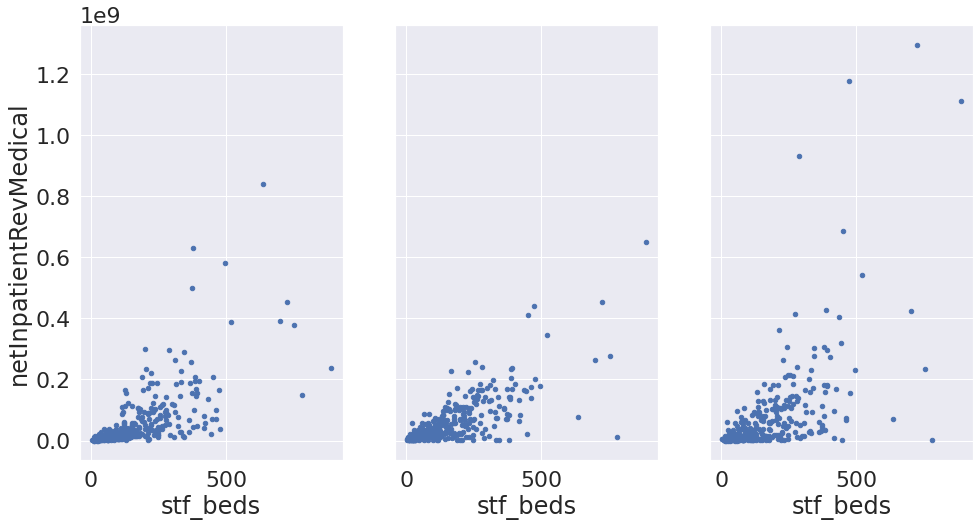

In [ ]:
fig, axs = plt.subplots(1, 3, sharey=True)
df.plot(kind='scatter', x='stf_beds', y='netInpatientRevMedical', ax=axs[0], figsize=(16, 8))
df.plot(kind='scatter', x='stf_beds', y='netInpatientRevMedicare', ax=axs[1])
df.plot(kind='scatter', x='stf_beds', y='netInpatientRevThirdParty', ax=axs[2])

## Revenue per staff bed. 

In [ ]:
drg codes x # of discharges

# Modeling

## Simple OLS

In [ ]:
# this is the standard import if you're using "formula notation" (similar to R)
import statsmodels.formula.api as smf

columns = list(df)
print(columns)
# create a fitted model in one line
lm = smf.ols(formula='costToChargeRation ~ stf_beds', data=df).fit()

# print the coefficients
# lm.params

['stf_beds', 'total_discharges', 'facility_county_name', 'facility_number', 'facility_name', 'rank', 'msdrg_code', 'msdrg_description', 'no_of_discharges', 'avg_chg', 'avg_chg_statewide', 'percent_change', 'year', 'LICENSE_NUM', 'FACILITY_LEVEL_DESC', 'DBA_ADDRESS1', 'DBA_CITY', 'DBA_ZIP_CODE', 'COUNTY_CODE', 'COUNTY_NAME', 'ER_SERVICE_LEVEL_DESC', 'TOTAL_NUMBER_BEDS', 'FACILITY_STATUS_DESC', 'FACILITY_STATUS_DATE', 'LICENSE_TYPE_DESC', 'LICENSE_CATEGORY_DESC', 'LONGITUDE', 'LATITUDE', 'hsa', 'op_status', 'hfpa', 'type_cntrl', 'type_hosp', 'teach_rurl', 'lic_beds', 'avl_beds', 'grossInpatientRevPerDischarge', 'grossInpatientRevPerDay', 'grossOutpatientRevPerDay', 'netInpatientRev', 'netInpatientRevMedicare', 'netInpatientRevMedical', 'netInpatientRevThirdParty', 'costToChargeRatio', 'geo_id', 'gini_index', 'median_rent', 'median_income', 'total_pop', 'poverty', 'state_fips_code', 'county_fips_code', 'county_total_discharges', 'county_market_share', 'county_hhi']


PatsyError: ignored

In [ ]:

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
np.random.seed(9876789)

# check frequencies of all data
# descriptive statistics
# bivariate 
# outliers?
# are you going to trim? 
# put year in dummy variable

features = [
            'stf_beds',
#  'total_discharges',
 'no_of_discharges',
#  'percent_change',
#  'FACILITY_LEVEL_DESC',
#  'ER_SERVICE_LEVEL_DESC',
#  'FACILITY_STATUS_DESC',
#  'FACILITY_STATUS_DATE',
#  'LICENSE_TYPE_DESC',
#  'LICENSE_CATEGORY_DESC',
#  'type_cntrl',
#  'type_hosp',
#  'teach_rurl',
#  'grossInpatientRevPerDischarge',
#  'grossInpatientRevPerDay',
#  'grossOutpatientRevPerDay',
#  'netInpatientRev',
#  'netInpatientRevMedicare',
#  'netInpatientRevMedical',
#  'netInpatientRevThirdParty',
#  'costToChargeRatio',
#  'gini_index',
 'median_rent',
 'median_income',
 'total_pop',
 'poverty',
#  'county_total_discharges',
#  'county_market_share',
#  'county_hhi'
 ]
X_LIST = []

import statsmodels.api as sm
msdrgs = df['msdrg_description'].unique()
parameters = 'stf_beds'

for drg in msdrgs:
  df_data = df[df['msdrg_description']==drg]
  for feature in features: 
    y = df['avg_chg']
    X_LIST.append(feature)
    X = df[X_LIST]
    X = sm.add_constant(X)
    model = sm.OLS(y.astype(float),X.astype(float))
    results = model.fit()
    print(results.summary())
    print(results.pvalues)
  break



                            OLS Regression Results                            
Dep. Variable:                avg_chg   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     11.98
Date:                Thu, 27 May 2021   Prob (F-statistic):           0.000541
Time:                        07:32:34   Log-Likelihood:                -75404.
No. Observations:                6105   AIC:                         1.508e+05
Df Residuals:                    6103   BIC:                         1.508e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.821e+04   1197.291     31.912      0.0

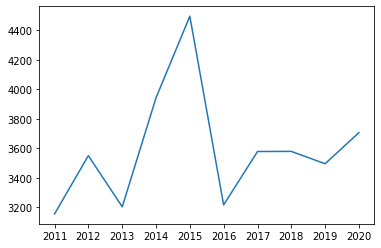

In [ ]:
# Multiple lines in same plot
x=np.linspace(1,10,200)

# Plot
plt.plot(df_year)
# plt.plot(x,np.log(x))

# # Decorate
# plt.xlabel('x')
# plt.title('Sin and Log')
# plt.xlim(1,10)
# plt.ylim(-1.0 , 2.5)
plt.show()

In [ ]:
df_cpt = df[['year', 'cpt_code', 'avg_charge']]
top_list = df_cpt.groupby(['cpt_code'])['avg_charge'].count().sort_values(ascending=False)
top_list.head(10)

cpt_code
80048.0    1862
80053.0    1844
80061.0    1809
85025.0    1792
70450.0    1748
85027.0    1727
82550.0    1708
84443.0    1707
99283.0    1686
85610.0    1680
Name: avg_charge, dtype: int64

In [ ]:
cpt_code	cpt_desc
99283.0	Er Level 3
80048.0	Metabolic panel total ca
85027.0	HEMOGRAM/PLATELET AUTO
85025.0	Complete cbc w/auto diff wbc
80053.0	Comprehensive Metabolic Panel
82550.0	"Creatine Kinase (CK), (CPK), Total"
80061.0	Lipid Panel
84443.0	Thyroid Stimulating Hormone


SyntaxError: ignored

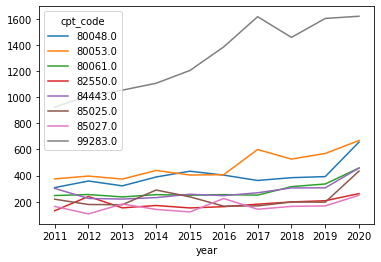

In [ ]:
codes =['80048.0','80053.0','80061.0','85025.0','85027.0', '84443.0','82550.0','99283.0']
df_plot = df_cpt[df_cpt.cpt_code.isin(codes)]
df_plot = df_plot.groupby(['year','cpt_code'])['avg_charge'].mean()
df_plot.unstack(fill_value=0).plot.line()

In [ ]:
codes =['80048.0','80053.0','80061.0','85025.0','85027.0', '84443.0','82550.0','99283.0']
df_pivot = df[df.cpt_code.isin(codes)]
# df_plot
df_pivot = df_pivot[pd.DatetimeIndex(df_pivot.year).year==2019].pivot(index='oshpd_id', columns='cpt_code', values='avg_charge')

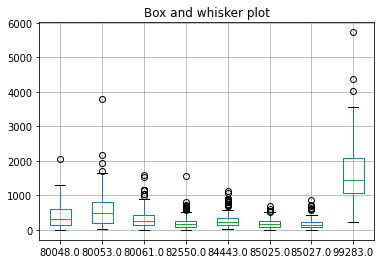

In [ ]:
df_pivot.plot.box(title="Box and whisker plot", grid=True);


In [ ]:
df_pivot